# ARIMA-收盘价预测

In [2]:
import pandas as pd
import tushare as ts
import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = 15, 5
%matplotlib inline

## 数据获取&处理

In [3]:
# 读取数据：2018-01-02~2020-12-31收盘价
datas = pd.read_excel('../data/data.xlsx')['close']
index = pd.read_excel('../data/data.xlsx')['date']
data = pd.DataFrame(data=np.array(datas),index=index,columns=['close'])
data.sort_index(inplace=True)
data.head(10)

,close
date,
2018-01-02,8.25
2018-01-03,8.33
2018-01-04,8.28
2018-01-05,8.24
2018-01-08,8.30
2018-01-09,8.42
2018-01-10,8.32
2018-01-11,8.36
2018-01-12,8.41


Text(0.5, 1.0, 'Snow boy Closing rate - Year 2018')

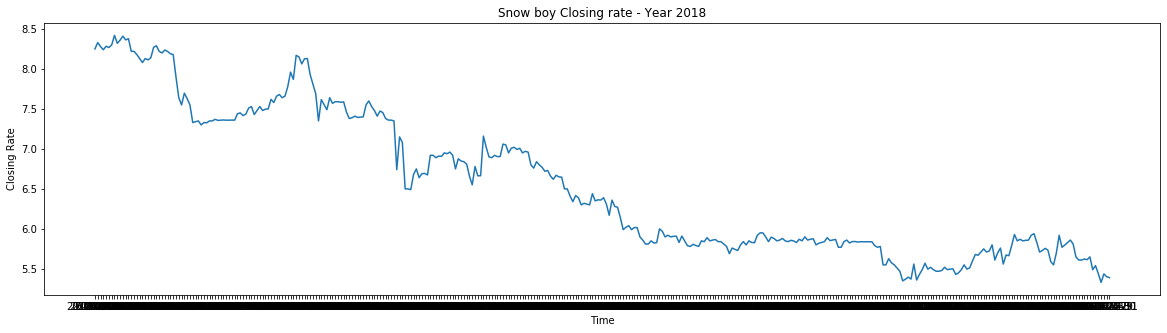

In [4]:
# 缺失数据处理：取前三个的平均值
begin = datetime.date(2018,1,2)
end = datetime.date(2018,12,31)
d = begin
delta = datetime.timedelta(days=1)
indexs = np.array(data.index)
while d <= end:
    cur = d.strftime("%Y-%m-%d")
    if cur not in indexs:
        before1 = (d-delta)
        before2 = (before1-delta)
        before3 = before2 - delta
        data.loc[cur] = [(data.at[before1.strftime("%Y-%m-%d"),'close'] + data.at[before2.strftime("%Y-%m-%d"),'close'] + 
                         data.at[before3.strftime("%Y-%m-%d"),'close'] )/3]
    d += delta
data.sort_index(inplace=True)
plt.figure(figsize=(20,5))
plt.plot(data.index,data['close'])
plt.xlabel('Time')
plt.ylabel('Closing Rate')
plt.title('Snow boy Closing rate - Year 2018')

## 平稳性检验

如果是非平稳的，变化是无规律的，那么也就没有去寻找规律的必要了。

### 原数据

In [5]:
def evaluate_stationarity(timeseries,t):
    # 将序列分为长度为t的小区间，并求其平均值、标准差，长度不足t的置为NaN
    rol_mean = timeseries.rolling(window=t).mean()  
    rol_std = timeseries.rolling(window=t).std()
    
    # 绘制图像
    origin_data = plt.plot(timeseries,color='blue',label='Original Data')
    mean = plt.plot(rol_mean,color='red',label='Rolling Mean')
    std = plt.plot(rol_std,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Augmented Dickey-Fuller平稳性检测
    print('Dickey-Fuller Test:')
    df_test = adfuller(timeseries)
    df_result = pd.Series(df_test[0:4],index=['测试统计', 'p-value', '使用延迟', '使用的观察次数'])
    for key,value in df_test[4].items():
        df_result['Cirtical Value (%s)' % key] = value
    print(df_result)

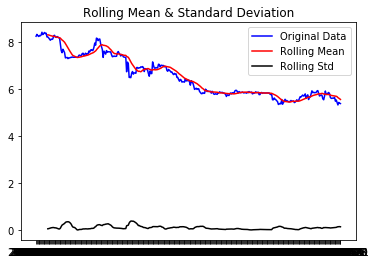

Dickey-Fuller Test:
测试统计                     -1.787870
p-value                   0.386501
使用延迟                     10.000000
使用的观察次数                 353.000000
Cirtical Value (1%)      -3.449011
Cirtical Value (5%)      -2.869763
Cirtical Value (10%)     -2.571151
dtype: float64


In [6]:
evaluate_stationarity(data['close'],15)

**结果及分析**
1. 从图像上看，滚动标准差和均值随着时间波动较大，初步认定其为非平稳的；
2. 从检验结果上看，P-value(显著性水平)很大，且测试结果较1%、%5、10%不同程度拒绝原假设的统计值都大，且相差较大；

### 取对数

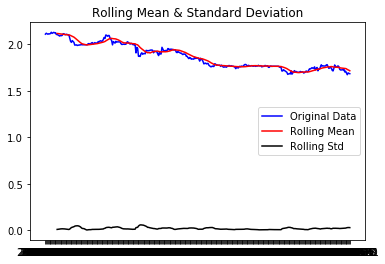

Dickey-Fuller Test:
测试统计                     -1.339747
p-value                   0.610798
使用延迟                      5.000000
使用的观察次数                 358.000000
Cirtical Value (1%)      -3.448749
Cirtical Value (5%)      -2.869647
Cirtical Value (10%)     -2.571089
dtype: float64


In [7]:
data_log = np.log(data['close'])
evaluate_stationarity(data_log,15)

**结果和分析**  
进行对数转换后，可以看到：
1. 滚动标准差和均值随着时间波动仍较大，初步认定其为非平稳的；
2. 且从检验结果上看，P-value(显著性水平)很大，且测试结果较1%、%5、10%不同程度拒绝原假设的统计值都大，且相差较大；

### 对已对数化的数据作一阶差分处理

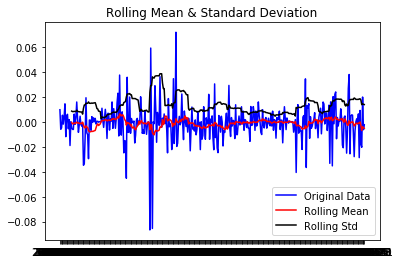

Dickey-Fuller Test:
测试统计                   -7.876789e+00
p-value                 4.820132e-12
使用延迟                    4.000000e+00
使用的观察次数                 3.580000e+02
Cirtical Value (1%)    -3.448749e+00
Cirtical Value (5%)    -2.869647e+00
Cirtical Value (10%)   -2.571089e+00
dtype: float64


In [8]:
data_log_diff = data_log - data_log.shift()
data_log_diff.dropna(inplace=True)
evaluate_stationarity(data_log_diff,15)

此时可以从图像中看到，对数化数据的一阶差分的滚动均值和方差在时间序列上很少该改变，而且其p-value几乎为0，也较1%、%5、10%不同程度拒绝原假设的统计值要小很多。提高了时间序列的平稳性。那么可以确定ARIMA模型中的`(p,i,q)`的`i=1`

## 确定模型阶数p，q 

### ACF&PACF

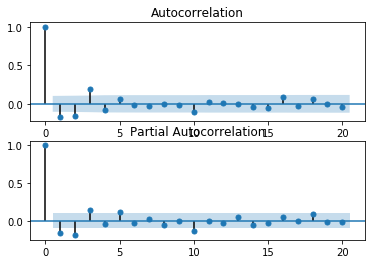

In [9]:
ax1 = plt.subplot(211)
# 绘制自相关函数ACF
fig = sm.graphics.tsa.plot_acf(data_log_diff.squeeze(), lags=20, ax=ax1)
ax2 = plt.subplot(212)
# 绘制偏自相关函数PACF
fig = sm.graphics.tsa.plot_pacf(data_log_diff, lags=20, ax=ax2)

![](../images/acf&pacf.jpg)

通俗地说，PACF**最后一个在蓝线外（即阈值外）**的Lag值就是p值；ACF**最后一个在蓝线外（即阈值外）**的Lag值就是q值。  
因此，**p和q均取3**

### 残差检验

为了确保确定的阶数合适，还需要进行残差检验，残差是随机正态分布的、不自相关的，这说明残差是一段白噪声信号。

> 残差即原始数据减掉模型拟合出的数据后的残余数据。

In [10]:
# ARIMA模型预测
model = ARIMA(data_log, order=(3, 1, 3))
results_ARIMA_313 = model.fit(disp=-1)
predictions_ARIMA_diff = pd.Series(results_ARIMA_313.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head(10))

date
2018-01-03   -0.001175
2018-01-04   -0.002939
2018-01-05   -0.002388
2018-01-06    0.001831
2018-01-07   -0.002537
2018-01-08   -0.001676
2018-01-09   -0.001642
2018-01-10   -0.004550
2018-01-11   -0.001476
2018-01-12    0.002520
dtype: float64


In [11]:
# 计算残差，并使用Durbin Watson统计
data_residual = predictions_ARIMA_diff - data_log_diff
sm.stats.durbin_watson(data_residual)

1.999451198024607

> Durbin Watson统计用于确定数据内自相关存在性的统计方法，通过计算残差之间的自相关来实现。

**结果分析：Durbin Watson统计结果返回的是介于0和4之间的数字，其中0表示强正自相关，4表示强负自相关，2表示无自相关。而差分后的时间序列返回的是1.999451198024607，接近于2，表明了残差是一段白噪声信号，有用的数据已经都被提取到ARMA模型中**

In [12]:
# 查看预测序列的AIC分数，AIC得分越低，时间序列模型质量越好。
print(results_ARIMA_313.aic)

-2069.4662576637197


综上，**最终的阶数**`(p,i,q) = (3,1,3)`

## 预测数据

### 还原数据

In [35]:
# data_log_diff 一阶差分；data_log 对数变换 predictions_ARIMA_diff 预测一阶差分
diff_shift = data_log.shift(1)  # 一阶差分还原
diff_recover = predictions_ARIMA_diff.add(diff_shift)
log_recover = np.exp(diff_recover)  # 对数还原
log_recover.dropna(inplace=True)
log_recover.head(10)

date
2018-01-03    8.240314
2018-01-04    8.305551
2018-01-05    8.260248
2018-01-06    8.255101
2018-01-07    8.262349
2018-01-08    8.253935
2018-01-09    8.286379
2018-01-10    8.381776
2018-01-11    8.307725
2018-01-12    8.381098
dtype: float64

### 预测数据同原数据对比

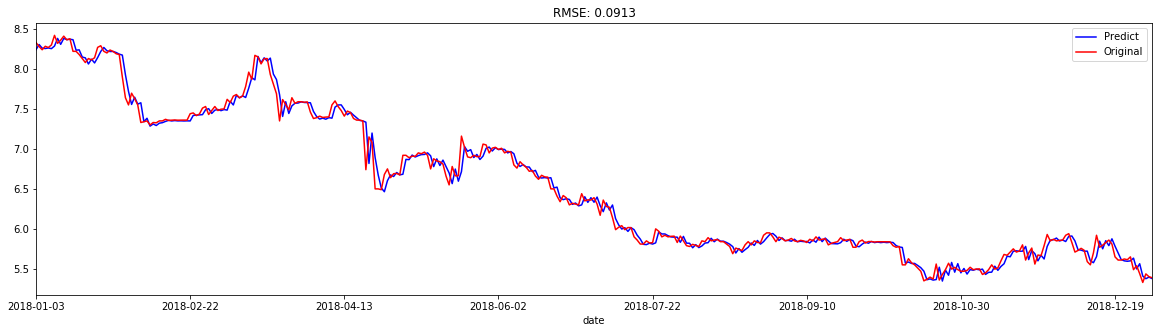

In [38]:
datas = data['close'][1:]
plt.figure(facecolor='white',figsize=(20,5))
log_recover.plot(color='blue', label='Predict')
datas.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((np.array(log_recover)-np.array(datas))**2)/data.size))
plt.show()